<a href="https://colab.research.google.com/github/JasonManesis/Least-Squares-Adjustment-of-Horizontal-Geodetic-Network/blob/main/Minimum_External_Constraints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Definition of the network properties. 

In [1]:
#Import modules.
import numpy as np
import sympy as sp
import sys
from sympy import symbols, diff
from numpy.linalg import multi_dot
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [2]:
n = 16 #number of measuremens.
v = 5 #number of network nodes.
d = 3 #imperfections : position and orientation = 2+1 =3
m = 2*v-d #number of unknown parameters.
r = n - m #degrees of freedom.

#Set numpy's print options.
np.set_printoptions(suppress=True,threshold=np.inf,linewidth=300,precision=15) 

print("The design matrix A has dimensions of {}x{} elements".format(n,m))
print("The weight matrix P has dimensions of {}x{} elements".format(n,n))

#We assume that: 
# 0 = Α
# 1 = B = constant and a_12 = a_BC = constant 
# 2 = C
# 3 = D
# 4 = E          

The design matrix A has dimensions of 16x7 elements
The weight matrix P has dimensions of 16x16 elements


In [3]:
#Matrices of measurements and standard errors.
l = np.array([64.1902,50.8882,32.4675,60.7616,26.2679,43.1958,92.6467,29.5762,106.2276,116.6508,112.9705,64.1595,490.249,220.725,791.552,659.535]) #array which includes all measurements. (angles+lengths)
noa = 12 #number of angles 
sigma_1 = np.array([25]*noa) #the standard error is in cc!
sigma_2 = np.array([0.012]*(l.shape[0]-noa)) #the standard error is in meters!
sigma = np.concatenate((sigma_1,sigma_2))

In [4]:
#Temporary coordinates of network nodes.
x = np.array([1586.537,2075.094,2222.679,1449.130,1688.320])
y = np.array([937.235,896.541,354.801,522.664,741.395])

#Temporary distance S12.
S12 = np.sqrt((x[2]-x[1])**2+(y[2]-y[1])**2)

#Matrix of unknown parameters Χ : xA,yΑ,xA,yΑ,xA,yΑ,SBC
X=np.array([1586.537,  937.235, 1449.13 ,  522.664, 1688.320, 741.395, S12])  
X  

array([1586.537          ,  937.235          , 1449.13           ,  522.664          , 1688.32           ,  741.395          ,  561.4833566767585])

In [5]:
#Create the necessary variables.
b_jik, a_ik, a_ij = symbols("b_jik, a_ik, a_ij ")
y_i,y_j,y_k = symbols("y_i,y_j,y_k")
x_i,x_j,x_k = symbols("x_i,x_j,x_k")
S_ij,S_ik = symbols("S_ij,S_ik")
dx_i,dx_j,dx_k = symbols("dx_i,dx_j,dx_k")
dy_i,dy_j,dy_k = symbols("dy_i,dy_j,dy_k")

#Auxiliary indices.
jj = np.array([2,5,1,5,4,5,3,5,1,4,3,2,2,5,3,3])-1
ii = np.array([1,1,4,4,3,3,2,2,5,5,5,5,1,1,4,5])-1
kk = np.array([5,4,5,3,5,2,5,1,2,1,4,3])-1

eqs = np.empty(shape=(n,), dtype=object)

In [6]:
#Linearized angle equations.
angle_eq = ((y_j-y_i)/S_ij**2 - (y_k-y_i)/S_ik**2)*dx_i + ((x_k-x_i)/S_ik**2 - (x_j-x_i)/S_ij**2)*dy_i - dx_j*(y_j-y_i)/S_ij**2 + dy_j*(x_j-x_i)/S_ij**2 + dx_k*(y_k-y_i)/S_ik**2 - dy_k*(x_k-x_i)/S_ik**2
angle_eq

dx_i*(-(-y_i + y_k)/S_ik**2 + (-y_i + y_j)/S_ij**2) + dy_i*((-x_i + x_k)/S_ik**2 - (-x_i + x_j)/S_ij**2) + dx_k*(-y_i + y_k)/S_ik**2 - dy_k*(-x_i + x_k)/S_ik**2 - dx_j*(-y_i + y_j)/S_ij**2 + dy_j*(-x_i + x_j)/S_ij**2

In [7]:
#Linearized distance equations.
dist_eq = -(x_j-x_i)/S_ij*dx_i-dy_i*(y_j-y_i)/S_ij+(x_j-x_i)/S_ij*dx_j+dy_j*(y_j-y_i)/S_ij
dist_eq

dx_i*(x_i - x_j)/S_ij + dx_j*(-x_i + x_j)/S_ij - dy_i*(-y_i + y_j)/S_ij + dy_j*(-y_i + y_j)/S_ij

In [8]:
def finda(dx,dy,a):
  '''This function calculates the true value of an azimuth angle'''
  if dx>0:
    if dy>0:return 200*a/math.pi 
    if dy==0:return 100
    if dy<0:return 200+200*a/math.pi
  if dx<0:
    if dy>0:return 400+200*a/math.pi 
    if dy==0:return 300
    if dy<0:return 200+200*a/math.pi  
  if dx==0:
    if dy>0:return 0
    if dy==0:return print("Division by 0!")
    if dy<0:return 200     

# Creation of design matrix Α.

In [9]:
#Create auxiliary vector.
dx_0,dy_0,dx_1,dy_1,dx_2,dy_2,dx_3,dy_3,dx_4,dy_4,dS_12 = symbols('dx_0,dy_0,dx_1,dy_1,dx_2,dy_2,dx_3,dy_3,dx_4,dy_4,dS_12')

DX = [dx_0,dy_0,
      dx_3,dy_3,
      dx_4,dy_4,
      dS_12]
DX 

[dx_0, dy_0, dx_3, dy_3, dx_4, dy_4, dS_12]

In [10]:
#Construction of the 16 observation equations.
for i in range(eqs.shape[0]):
  Sij = np.sqrt((x[jj[i]]-x[ii[i]])**2)+np.sqrt((y[jj[i]]-y[ii[i]])**2)
  if i<=noa-1:
    Sik = np.sqrt((x[kk[i]]-x[ii[i]])**2)+np.sqrt((y[kk[i]]-y[ii[i]])**2)
    eqs[i]=angle_eq.subs([(x_i,x[ii[i]]),(x_j,x[jj[i]]),(x_k,x[kk[i]]),(y_i,y[ii[i]]),(y_j,y[jj[i]]),(y_k,y[kk[i]]),(S_ij,Sij),(S_ik,Sik),
                        (dx_i,symbols('dx_{}'.format(ii[i]))),
                        (dx_j,symbols('dx_{}'.format(jj[i]))),
                        (dx_k,symbols('dx_{}'.format(kk[i]))),
                        (dy_i,symbols('dy_{}'.format(ii[i]))),
                        (dy_j,symbols('dy_{}'.format(jj[i]))),
                        (dy_k,symbols('dy_{}'.format(kk[i])))
                        ])*636620
  else:
    eqs[i] = dist_eq.subs([(x_i,x[ii[i]]),(x_j,x[jj[i]]),(y_i,y[ii[i]]),(y_j,y[jj[i]]),(S_ij,Sij),
                        (dx_i,symbols('dx_{}'.format(ii[i]))),
                        (dx_j,symbols('dx_{}'.format(jj[i]))),
                        (dy_i,symbols('dy_{}'.format(ii[i]))),
                        (dy_j,symbols('dy_{}'.format(jj[i]))),
                                                ])

In [11]:
#Calculate the true value of the azimuth angle a_BC = a_12.
a = math.atan((x[2]-x[1])/(y[2]-y[1]))
a_12 = finda(x[2]-x[1],y[2]-y[1],a)

In [12]:
#Replace the variables with their true values.
for i,eq in enumerate(eqs):
  eqs[i]=eq.subs([(dx_1,x[1]),(dy_1,x[2])])
  eqs[i]=eq.subs([(dx_2,dS_12*math.sin(a_12*math.pi/200)),(dy_2,dS_12*math.cos(a_12*math.pi/200))])

In [13]:
#Differentiation of each equation with each one of the unknown parameters and creation of design matrix Α.         
A = np.zeros(shape=(n,m))
for i in range(0,n):
  for j in range(0,m):
      A[i,j] = diff(eqs[i],DX[j])
print('Array A is:\n')
print(A)  

Array A is:

[[ 1315.0125528590386    -378.8674748570014       0.                    0.                -1407.5009566940464    -731.5138371894911       0.               ]
 [ -541.2660903543328   -1018.6220388706048    -866.2348663397134     287.1082016811136    1407.5009566940464     731.5138371894911       0.               ]
 [ -866.2348663397134     287.1082016811136     202.17154110731892    439.06827427490697    664.0633252323945    -726.1764759560206       0.               ]
 [    0.                    0.                  784.643469445205     -170.51709910897642   -664.0633252323945     726.1764759560206     504.42651035250844 ]
 [    0.                    0.                 -120.58014421281054   -555.6593768470442     290.1753078147618     401.0868955767248    -193.7150886668107  ]
 [    0.                    0.                    0.                    0.                 -290.1753078147618    -401.0868955767248    -310.7114216856977  ]
 [    0.                    0.               

# Creation of matrix of the calculated values. 

In [14]:
#Creation of matrix of the calculated values.
delta_l = np.zeros(shape=(n,))

for i in range(n):

  if i<=noa-1: #If its a angle equation.
    
    div1 = (x_k-x_i)/(y_k-y_i)
    div2 = (x_j-x_i)/(y_j-y_i)

    d1=float(div1.subs([(x_i,x[ii[i]]),(x_j,x[jj[i]]),(x_k,x[kk[i]]),(y_i,y[ii[i]]),(y_j,y[jj[i]]),(y_k,y[kk[i]])]))
    d2=float(div2.subs([(x_i,x[ii[i]]),(x_j,x[jj[i]]),(y_i,y[ii[i]]),(y_j,y[jj[i]]),(y_k,y[kk[i]])]))

    aik_ = np.arctan(d1)
    aij_ = np.arctan(d2)

    #Azimuth angle calculation.
    deltaX = x_k-x_i
    deltaY = y_k-y_i
    deltaX = float(deltaX.subs([(x_i,x[ii[i]]),(x_j,x[jj[i]]),(x_k,x[kk[i]]),(y_i,y[ii[i]]),(y_j,y[jj[i]]),(y_k,y[kk[i]])]))
    deltaY = float(deltaY.subs([(x_i,x[ii[i]]),(x_j,x[jj[i]]),(x_k,x[kk[i]]),(y_i,y[ii[i]]),(y_j,y[jj[i]]),(y_k,y[kk[i]])]))
    aik=finda(deltaX,deltaY,aik_)

    deltaX = x_j-x_i
    deltaY = y_j-y_i
    deltaX = float(deltaX.subs([(x_i,x[ii[i]]),(x_j,x[jj[i]]),(x_k,x[kk[i]]),(y_i,y[ii[i]]),(y_j,y[jj[i]]),(y_k,y[kk[i]])]))
    deltaY = float(deltaY.subs([(x_i,x[ii[i]]),(x_j,x[jj[i]]),(x_k,x[kk[i]]),(y_i,y[ii[i]]),(y_j,y[jj[i]]),(y_k,y[kk[i]])]))
    aij=finda(deltaX,deltaY,aij_)

    delta_l[i]=(l[i]-aik+aij) #in cc
    while delta_l[i]>399: delta_l[i]-=400
    delta_l[i]=delta_l[i]*10000 #convertion from grad to cc.

  else: #If its a distance equation.
    
    Sij = np.sqrt((x[jj[i]]-x[ii[i]])**2+(y[jj[i]]-y[ii[i]])**2) #distance calculation.
    delta_l[i]=l[i]-Sij #in meters 

delta_l    

array([-59.5602269456208  ,  -1.328985675570493,   0.54263166884283 ,   0.376205193788337,  -0.273873615697084,   0.715280497161075,   0.054504408808498,   0.47446446842514 ,  -0.91423752337505 ,  65.78635400671828 ,  -0.102331578091253,  19.23021509455225 ,   0.000140863132685,
         0.014590891140813,  -0.000930744369043,  -0.006099338775243])


# Creation of the weight matrix P.

In [15]:
#Define the a-priori standard error.
sigma_0 = 1 

I = np.identity(n)
P = I*(sigma_0/sigma)**2

print('Array P is:\n')
print(P)

Array P is:

[[   0.0016            0.                0.                0.                0.                0.                0.                0.                0.                0.                0.                0.                0.                0.                0.                0.            ]
 [   0.                0.0016            0.                0.                0.                0.                0.                0.                0.                0.                0.                0.                0.                0.                0.                0.            ]
 [   0.                0.                0.0016            0.                0.                0.                0.                0.                0.                0.                0.                0.                0.                0.                0.                0.            ]
 [   0.                0.                0.                0.0016            0.                0.                0

#System solution.

In [16]:
#Calculate the new array with the adjusted coordinate values of network nodes A,D,E and distance SBC.
delta_x=np.dot(np.linalg.inv(multi_dot([A.T,P,A])),multi_dot([A.T,P,delta_l]))
X_hat = X+delta_x
X_hat

array([1586.5398563952517,  937.268154332407 , 1449.1259086730727,  522.6498289885703, 1688.3261710305887,  741.4083775091273,  561.4740755472986])

In [17]:
#Points Β=1 και C=2.
x_1 = x[1]
y_1 = y[1]

#Calculate the final coordinates of the node C=2.

#With:
# x_2 = X_hat[-1]*math.sin(a_12*math.pi/200) + x[1]
# y_2 = X_hat[-1]*math.cos(a_12*math.pi/200) + y[1]

#Or:
x_2 = delta_x[-1]*math.sin(a_12*math.pi/200) + x[2]
y_2 = delta_x[-1]*math.cos(a_12*math.pi/200) + y[2]

In [18]:
#Create a new array with the adjusted coordinate values of all network nodes.
X_hat_extended = np.array([X_hat[0], X_hat[1], x_1,y_1,x_2,y_2, X_hat[2], X_hat[3],  X_hat[4], X_hat[5]])
X_hat_extended

array([1586.5398563952517,  937.268154332407 , 2075.094          ,  896.541          , 2222.676560470003 ,  354.8099547784699, 1449.1259086730727,  522.6498289885703, 1688.3261710305887,  741.4083775091273])

#Calculation of the a-priori variance-covariance matrix.



In [19]:
#Define the a-priori standard error.
sigma_0 = 1 

#Calculate the a-priori variance-covariance matrix.
V_x_hat = (sigma_0**2)*np.linalg.inv(multi_dot([A.T,P,A]))

V_x_hat

array([[ 0.000149225782628,  0.000089128015268,  0.00003943599029 ,  0.000143785484287,  0.000088839903659,  0.000085787304437,  0.000007578553423],
       [ 0.000089128015268,  0.00040034358534 , -0.000049529880227,  0.000382645652888,  0.000003153009971,  0.000276669530492, -0.000202752323251],
       [ 0.00003943599029 , -0.000049529880227,  0.000231870066259,  0.000139662398354,  0.000063906361852, -0.000025192174508,  0.000119084479721],
       [ 0.000143785484287,  0.000382645652888,  0.000139662398354,  0.00111408479694 , -0.00005993074636 ,  0.000369278086524, -0.000273087774062],
       [ 0.000088839903659,  0.000003153009971,  0.000063906361852, -0.00005993074636 ,  0.000143251462787, -0.000005787026201,  0.000114834167512],
       [ 0.000085787304437,  0.000276669530492, -0.000025192174508,  0.000369278086524, -0.000005787026201,  0.000277722443448, -0.000201409020039],
       [ 0.000007578553423, -0.000202752323251,  0.000119084479721, -0.000273087774062,  0.000114834167512

#Computation of the a posteriori standard error.

In [20]:
#Calculation of the a-posteriori standard error.
u = np.dot(A,delta_x)-delta_l
sigma_0_hat = np.sqrt(multi_dot([u.T,P,u])/(n-m))
sigma_0_hat

0.9684956769038704

In [21]:
#Create the necessary auxiliary variables and vectors.
x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,S_12 = symbols('x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,S_12')
DX_1 = np.array([x_0,y_0,x_3,y_3,x_4,y_4,S_12*math.sin(a_12*math.pi/200),S_12*math.cos(a_12*math.pi/200),x_1,y_1])
DX_2 = np.array([x_0,y_0,x_3,y_3,x_4,y_4,S_12])

#Calculation of the necessary Jacobian matrix for the propagation of uncertainty between the two vectors DX_1, DX_2.
J = np.zeros(shape=(2*v,V_x_hat.shape[0]))
for i in range(0,2*v):
  for j in range(V_x_hat.shape[0]):
      J[i,j] = diff(DX_1[i],DX_2[j])
print('Array J is:\n')
print(J) 

Array J is:

[[ 1.                 0.                 0.                 0.                 0.                 0.                 0.               ]
 [ 0.                 1.                 0.                 0.                 0.                 0.                 0.               ]
 [ 0.                 0.                 1.                 0.                 0.                 0.                 0.               ]
 [ 0.                 0.                 0.                 1.                 0.                 0.                 0.               ]
 [ 0.                 0.                 0.                 0.                 1.                 0.                 0.               ]
 [ 0.                 0.                 0.                 0.                 0.                 1.                 0.               ]
 [ 0.                 0.                 0.                 0.                 0.                 0.                 0.262848396564252]
 [ 0.                 0.           

In [22]:
#Calculation of the a-priori variance-covariance matrix of the coordinates of all network nodes.
V_x_hat_extended = multi_dot([J,V_x_hat,J.T])
V_x_hat_extended_df = pd.DataFrame(V_x_hat_extended,index=["0","00","3","33","4","44","2","22","1","11"], columns=["0","00","3","33","4","44","2","22","1","11"])
V_x_hat_extended_df=V_x_hat_extended_df.sort_index()
V_x_hat_extended_df=V_x_hat_extended_df.reindex(sorted(V_x_hat_extended_df.columns), axis=1)
V_x_hat_extended = np.array(V_x_hat_extended_df)
V_x_hat_extended

array([[ 0.000149225782628,  0.000089128015268,  0.               ,  0.               ,  0.000001992010615, -0.000007312069863,  0.00003943599029 ,  0.000143785484287,  0.000088839903659,  0.000085787304437],
       [ 0.000089128015268,  0.00040034358534 ,  0.               ,  0.               , -0.000053293123066,  0.000195622973133, -0.000049529880227,  0.000382645652888,  0.000003153009971,  0.000276669530492],
       [ 0.               ,  0.               ,  0.               ,  0.               ,  0.               ,  0.               ,  0.               ,  0.               ,  0.               ,  0.               ],
       [ 0.               ,  0.               ,  0.               ,  0.               ,  0.               ,  0.               ,  0.               ,  0.               ,  0.               ,  0.               ],
       [ 0.000001992010615, -0.000053293123066,  0.               ,  0.               ,  0.000033670076858, -0.00012359269192 ,  0.00003130116455 , -0.0000717806835

#Graphical representation of the error ellipses.

In [23]:
#Final coordinates of network nodes.
x_hat = np.zeros(shape=(v,))
y_hat = np.zeros(shape=(v,))

j=0
for i in range(0,v):
  x_hat[i] = X_hat_extended[j]
  y_hat[i] = X_hat_extended[j+1]
  if j%2==0:j+=2

#Network edges.
lines_x = np.concatenate((x_hat,np.array([x_hat[0],x_hat[4],x_hat[1],x_hat[4],x_hat[2],x_hat[4],x_hat[3],x_hat[4],x_hat[0],x_hat[3]])))
lines_y = np.concatenate((y_hat,np.array([y_hat[0],y_hat[4],y_hat[1],y_hat[4],y_hat[2],y_hat[4],y_hat[3],y_hat[4],y_hat[0],y_hat[3]])))
X_hat_extended

array([1586.5398563952517,  937.268154332407 , 2075.094          ,  896.541          , 2222.676560470003 ,  354.8099547784699, 1449.1259086730727,  522.6498289885703, 1688.3261710305887,  741.4083775091273])

In [24]:
def auxfunc(V_xy):

  '''This function takes as argument the variance-covariance submatrix of the corresponding 
  network node or edge, and as output it returns the absolute or relative ellipse properties.'''

  width, height, angle =0,0,0
  
  if (V_xy[0,1]+V_xy[0,0]-V_xy[1,1])!=0: 

    #Define equations for the calculation of the semi-major axis, the semi-minor axis and the orientation of the error ellipse. 
    sigma_x_sq,sigma_y_sq,sigma_xy = symbols('sigma_x_sq,sigma_y_sq,sigma_xy')
    sigma_max_squared = ((sigma_x_sq+sigma_y_sq)+((sigma_x_sq-sigma_y_sq)**2+4*sigma_xy**2)**0.5)/2
    sigma_min_squared = ((sigma_x_sq+sigma_y_sq)-((sigma_x_sq-sigma_y_sq)**2+4*sigma_xy**2)**0.5)/2
    tan_2theta = 2*sigma_xy/(sigma_x_sq-sigma_y_sq)

    #Calculate the length of the semi-major and the semi-minor ellipse axes.
    sigma_max_squared = sigma_max_squared.subs([(sigma_x_sq,V_xy[0,0]),(sigma_y_sq,V_xy[1,1]),(sigma_xy,V_xy[0,1])])
    sigma_min_squared = sigma_min_squared.subs([(sigma_x_sq,V_xy[0,0]),(sigma_y_sq,V_xy[1,1]),(sigma_xy,V_xy[0,1])])
    sigma_u=sigma_max_squared**0.5
    sigma_v=sigma_min_squared**0.5
    width = 2*sigma_u
    height = 2*sigma_v

    #Calculate the orientation of the error ellipse.
    tan_2theta = tan_2theta.subs([(sigma_x_sq,V_xy[0,0]),(sigma_y_sq,V_xy[1,1]),(sigma_xy,V_xy[0,1])])
    theta = math.atan(tan_2theta)*180/(2*math.pi)
    
    #Extract the variances and the covariances from the input matrix.
    sigma_x=V_xy[0,0]**0.5
    sigma_y=V_xy[1,1]**0.5
    sigma_xy=V_xy[0,1]

    #Angle investigation.
    if sigma_x>sigma_y:
      if sigma_xy>0:angle=theta
      if sigma_xy<0:angle=theta+180
    if sigma_x<sigma_y:
      if sigma_xy>0:angle=theta+90  
      if sigma_xy<0:angle=theta+90  
    if sigma_x==sigma_y:
      if sigma_xy>0:angle=45
      if sigma_xy<0:angle=135
 
  return width, height, angle

In [25]:
def ellipse_args(netnodecode1, netnodecode2=9999, V_x_hat=V_x_hat_extended):

  '''This function takes as arguments the specific network node for the calculation of the absolute error ellipse properties, or
  the two network nodes of the corresponding network edge in wich we want to calculate the relative error ellipse arguments. 
  Aditionally this function takes as argument the variance-covariance matrix of the coordinates of all network nodes. As output,
  it extracts the absolute or relative ellipse properties.'''
  
  netnodecode=netnodecode1
  if netnodecode < 5:

    if netnodecode2 == 9999: #If we want to calculate the absolute error ellipse.
      
      #Extract the variance-covariance submatrix of the given network node.
      V_xy = V_x_hat[2*netnodecode:2*netnodecode+2,2*netnodecode:2*netnodecode+2]
      width, height, angle = auxfunc(V_xy)
      return width, height, angle

    elif netnodecode2 < 5: #If we want to calculate the relative error ellipse.
      
      Jrij = np.array([[-1,0,1,0],[0,-1,0,1]])
      Vrig = np.ones(shape=(4,4))

      #Extract the variance-covariance submatrix of the given network edge.
      V_xy1 = V_x_hat[2*netnodecode1:2*netnodecode1+2,2*netnodecode1:2*netnodecode1+2] 
      V_xy2 = V_x_hat[2*netnodecode2:2*netnodecode2+2,2*netnodecode2:2*netnodecode2+2] 
      V1 = V_x_hat[2*netnodecode1:2*netnodecode1+2,2*netnodecode2:2*netnodecode2+2] 
      V2 = V_x_hat[2*netnodecode2:2*netnodecode2+2,2*netnodecode1:2*netnodecode1+2] 
      Vrig=np.asarray(np.bmat([[V_xy1, V1], [V2, V_xy2]]))

      VDrij = multi_dot([Jrij,Vrig,Jrij.T])
      width, height, angle = auxfunc(VDrij)
      return width, height, angle
      
  else: return print("There is no network node with the given code name!")

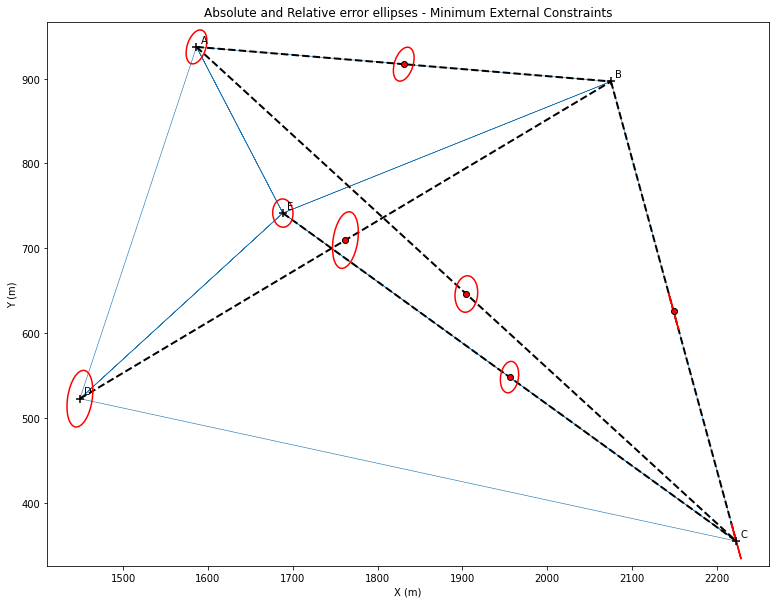

In [26]:
#Graphical representation of the error ellipses. 

fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, aspect='equal')

#Define plot options.
scalefactor = 1000
ld=1.5
ellcolor = 'red'
ellzorder = 4
pointzorder = 5

#Plot network edges.
plt.plot(lines_x, lines_y, linewidth=0.6, markersize=8, alpha=1)

#Plot network nodes.
plt.scatter(x_hat, y_hat, marker="+", zorder=pointzorder, s=70, c='black')

#Plot nodenames.
nodenames=["A","B","C","D","E"]
for i, txt in enumerate(nodenames):
    ax.annotate(txt, (x_hat[i], y_hat[i]), xytext=(x_hat[i]+5,y_hat[i]+5), zorder=pointzorder)

#Absolute error ellipses of all network nodes.
width, height, angle = ellipse_args(0)
ax.add_artist(Ellipse(xy=X_hat_extended[:2], width=width*scalefactor, height=height*scalefactor, angle=angle, fill=None, alpha=1, linewidth=ld, color=ellcolor, zorder=ellzorder))
width, height, angle = ellipse_args(1)
ax.add_artist(Ellipse(xy=X_hat_extended[2:4], width=width*scalefactor, height=height*scalefactor, angle=angle, fill=None, alpha=1, linewidth=ld, color=ellcolor, zorder=ellzorder))
width, height, angle = ellipse_args(2)
ax.add_artist(Ellipse(xy=X_hat_extended[4:6], width=width*scalefactor, height=height*scalefactor, angle=angle, fill=None, alpha=1, linewidth=ld, color=ellcolor, zorder=ellzorder))
width, height, angle = ellipse_args(3)
ax.add_artist(Ellipse(xy=X_hat_extended[6:8], width=width*scalefactor, height=height*scalefactor, angle=angle, fill=None, alpha=1, linewidth=ld, color=ellcolor, zorder=ellzorder))
width, height, angle = ellipse_args(4)
ax.add_artist(Ellipse(xy=X_hat_extended[8:], width=width*scalefactor, height=height*scalefactor, angle=angle, fill=None, alpha=1, linewidth=ld, color=ellcolor, zorder=ellzorder))

#Relative error ellipses between each station pair.

#Edge AC.
width, height, angle = ellipse_args(0,2)
xy=(X_hat_extended[:2]+X_hat_extended[4:6])/2
xx = np.array([x_hat[0],x_hat[2]])
yy = np.array([y_hat[0],y_hat[2]])
plt.plot(xx, yy, "k--", linewidth=2, markersize=4)
plt.plot((x_hat[0]+x_hat[2])/2,(y_hat[0]+y_hat[2])/2, marker=".", color='red', mec="black", markersize=12, zorder=pointzorder)
ax.add_artist(Ellipse(xy=xy, width=width*scalefactor, height=height*scalefactor, angle=angle, fill=None, alpha=1, linewidth=ld, color=ellcolor, zorder=ellzorder))

#Edge AB.
width, height, angle = ellipse_args(0,1)
xy=(X_hat_extended[:2]+X_hat_extended[2:4])/2
xx = np.array([x_hat[0],x_hat[1]])
yy = np.array([y_hat[0],y_hat[1]])
plt.plot(xx, yy, "k--", linewidth=2, markersize=4)
plt.plot((x_hat[1]+x_hat[0])/2,(y_hat[1]+y_hat[0])/2, marker=".", color='red', mec="black", markersize=12, zorder=pointzorder)
ax.add_artist(Ellipse(xy=xy, width=width*scalefactor, height=height*scalefactor, angle=angle, fill=None, alpha=1, linewidth=ld, color=ellcolor, zorder=ellzorder))

#Edge DB.
width, height, angle = ellipse_args(3,1)
xy=(X_hat_extended[6:8]+X_hat_extended[2:4])/2
xx = np.array([x_hat[3],x_hat[1]])
yy = np.array([y_hat[3],y_hat[1]])
plt.plot(xx, yy, "k--", linewidth=2, markersize=4)
plt.plot((x_hat[3]+x_hat[1])/2,(y_hat[3]+y_hat[1])/2, marker=".", color='red', mec="black", markersize=12, zorder=pointzorder)
ax.add_artist(Ellipse(xy=xy, width=width*scalefactor, height=height*scalefactor, angle=angle, fill=None, alpha=1, linewidth=ld, color=ellcolor, zorder=ellzorder))

#Edge EC.
width, height, angle = ellipse_args(4,2)
xy=(X_hat_extended[8:]+X_hat_extended[4:6])/2
xx = np.array([x_hat[4],x_hat[2]])
yy = np.array([y_hat[4],y_hat[2]])
plt.plot(xx, yy, "k--", linewidth=2, markersize=4)
plt.plot((x_hat[4]+x_hat[2])/2,(y_hat[4]+y_hat[2])/2, marker=".", color='red', mec="black", markersize=12, zorder=pointzorder)
ax.add_artist(Ellipse(xy=xy, width=width*scalefactor, height=height*scalefactor, angle=angle, fill=None, alpha=1, linewidth=ld, color=ellcolor, zorder=ellzorder))

#Edge BC.
width, height, angle = ellipse_args(1,2)
xy=(X_hat_extended[2:4]+X_hat_extended[4:6])/2
xx = np.array([x_hat[1],x_hat[2]])
yy = np.array([y_hat[1],y_hat[2]])
plt.plot(xx, yy, "k--", linewidth=2, markersize=4)
plt.plot((x_hat[1]+x_hat[2])/2,(y_hat[1]+y_hat[2])/2, marker=".", color='red', mec="black", markersize=12, zorder=pointzorder)
ax.add_artist(Ellipse(xy=xy, width=width*scalefactor, height=height*scalefactor, angle=angle, fill=None, alpha=1, linewidth=ld, color=ellcolor, zorder=ellzorder))

plt.title("Absolute and Relative error ellipses - Minimum Εxternal Constraints")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.show();

In [27]:
#Save the figure.
formatype='png'
fig.savefig("/content/sample_data/Error_Ellipses_Minimum_Εxternal_Constraints."+formatype, dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=formatype,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        metadata=None);